<font size="+3"><strong>6.5. Small Business Owners in the United States🇺🇸</strong></font>

In this assignment, you're going to focus on business owners in the United States. You'll start by examining some demographic characteristics of the group, such as age, income category, and debt vs home value. Then you'll select high-variance features, and create a clustering model to divide small business owners into subgroups. Finally, you'll create some visualizations to highlight the differences between these subgroups. Good luck! 🍀

In [95]:
# Import libraries here
import pandas as pd
import matplotlib.pyplot as plt
import os
import plotly.express as px
from dash import Input, Output, dcc, html
import seaborn as sns
from scipy.stats.mstats import trimmed_var
from dash import Dash
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# Prepare Data

## Import

Let's start by bringing our data into the assignment.

#### Task 6.5.1

In [96]:
df = pd.read_csv("data/SCFP2019.csv.gz")
print("df shape:", df.shape)
df.head()

df shape: (28885, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,...,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
2,1,13,5145.224455,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
3,1,14,5297.663412,2,75,6,12,4,2,0,...,5,2,6,2,1,10,4,4,2,2
4,1,15,4761.812371,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2


## Explore

As mentioned at the start of this assignment, you're focusing on business owners. But what percentage of the respondents in `df` are business owners?

#### Task 6.5.2

In [97]:
prop_biz_owners = df["HBUS"].mean()
print("proportion of business owners in df:", prop_biz_owners)

proportion of business owners in df: 0.2740176562229531


Is the distribution of income different for business owners and non-business owners?

#### Task 6.5.3


In [98]:
inccat_dict = {
    1: "0-20",
    2: "21-39.9",
    3: "40-59.9",
    4: "60-79.9",
    5: "80-89.9",
    6: "90-100",
}
df_inccat = (
    df["INCCAT"].replace(inccat_dict).groupby(df["HBUS"]).value_counts(normalize=True).
    rename("frequency").to_frame().reset_index()
)

df_inccat

,HBUS,INCCAT,frequency
0,0,0-20,0.210348
1,0,21-39.9,0.198140
2,0,40-59.9,0.189080
3,0,60-79.9,0.186600
4,0,90-100,0.117167
5,0,80-89.9,0.098665
6,1,90-100,0.629438
7,1,60-79.9,0.119015
8,1,80-89.9,0.097410
9,1,40-59.9,0.071510


<div class="alert alert-info" role="alert">
  <strong>Slight Code Change</strong>

In the following task, you'll notice a small change in how plots are created compared to what you saw in the lessons.
While the lessons use the global matplotlib method like <code>plt.plot(...)</code>, in this task, you are expected to use the object-oriented (OOP) API instead.
This means creating your plots using <code>fig, ax = plt.subplots()</code> and then calling plotting methods on the <code>ax</code> object, such as <code>ax.plot(...)</code>, <code>ax.hist(...)</code>, or <code>ax.scatter(...)</code>.

If you're using pandas’ or seaborn’s built-in plotting methods (like <code>df.plot()</code> or <code>sns.lineplot()</code>), make sure to pass the <code>ax=ax</code> argument so that the plot is rendered on the correct axes.

This approach is considered best practice and will be used consistently across all graded tasks that involve matplotlib.
</div>


#### Task 6.5.4

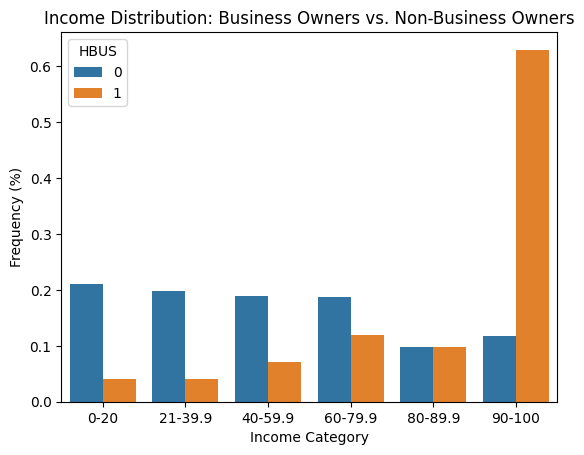

In [99]:
fig, ax = plt.subplots()

sns.barplot(
    data=df_inccat,x="INCCAT",y="frequency",hue="HBUS",order=inccat_dict.values()
)
plt.xlabel("Income Category")
plt.ylabel("Frequency (%)")
plt.title("Income Distribution: Business Owners vs. Non-Business Owners");


We looked at the relationship between home value and household debt in the context of the the credit fearful, but what about business owners? Are there notable differences between business owners and non-business owners?

#### Task 6.5.5

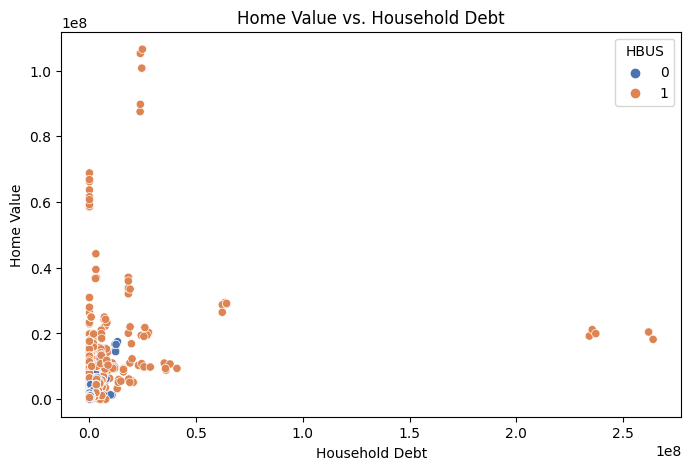

In [100]:
# Plot "HOUSES" vs "DEBT" with hue as business ownership
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(
    x=df["DEBT"],y=df["HOUSES"],hue=df["HBUS"],
    palette="deep"    
)
plt.xlabel("Household Debt")
plt.ylabel("Home Value")
plt.title("Home Value vs. Household Debt");


For the model building part of the assignment, you're going to focus on small business owners, defined as respondents who have a business and whose income does not exceed \\$500,000.

#### Task 6.5.6

In [101]:
mask = (df["HBUS"]==1) & (df["INCOME"]<500000)
df_small_biz = df[mask] # use the column `mask` defined above
print("df_small_biz shape:", df_small_biz.shape)
df_small_biz.head()

df_small_biz shape: (4364, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
80,17,171,7802.265717,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
81,17,172,8247.536301,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
82,17,173,8169.562719,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
83,17,174,8087.704517,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
84,17,175,8276.510048,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4


We saw that credit-fearful respondents were relatively young. Is the same true for small business owners?

#### Task 6.5.7

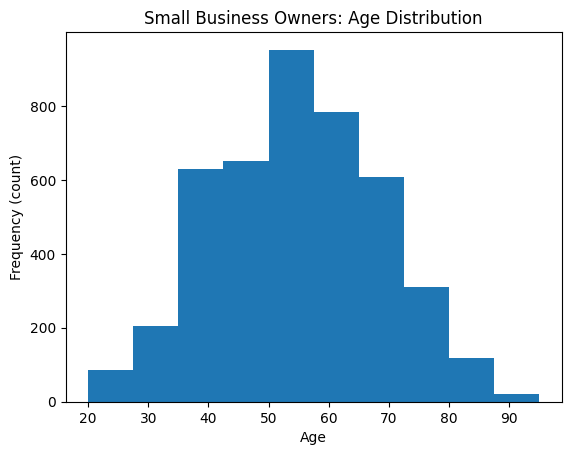

In [102]:
# Plot histogram of "AGE"
fig, ax = plt.subplots()
df_small_biz["AGE"].plot(
    kind="hist",
    bins=10,ax=ax
)
plt.xlabel("Age")
plt.ylabel("Frequency (count)")
plt.title("Small Business Owners: Age Distribution");



So, can we say the same thing about small business owners as we can about credit-fearful people?

Let's take a look at the variance in the dataset.

#### Task 6.5.8

In [103]:
# Calculate variance, get 10 largest features
top_ten_var =df_small_biz.var().sort_values().tail(10)
top_ten_var

EQUITY      1.005088e+13
FIN         2.103228e+13
KGBUS       5.025210e+13
ACTBUS      5.405021e+13
BUS         5.606717e+13
KGTOTAL     6.120760e+13
NHNFIN      7.363197e+13
NFIN        9.244074e+13
NETWORTH    1.424450e+14
ASSET       1.520071e+14
dtype: float64

We'll need to remove some outliers to avoid problems in our calculations, so let's trim them out.

#### Task 6.5.9

In [104]:
# Calculate trimmed variance
top_ten_trim_var = df_small_biz.apply(trimmed_var,limits=(0.1,0.1)).sort_values().tail(10)


top_ten_trim_var

EQUITY      1.177020e+11
KGBUS       1.838163e+11
FIN         3.588855e+11
KGTOTAL     5.367878e+11
ACTBUS      5.441806e+11
BUS         6.531708e+11
NHNFIN      1.109187e+12
NFIN        1.792707e+12
NETWORTH    3.726356e+12
ASSET       3.990101e+12
dtype: float64

Let's do a quick visualization of those values.

#### Task 6.5.10

In [105]:
# Create horizontal bar chart of `top_ten_trim_var`
fig = px.bar(x=top_ten_trim_var,y=top_ten_trim_var.index,title="Small Business Owners: High Variance Features",orientation="h")
fig.update_layout(xaxis_title="Trimmed Variance [$]",yaxis_title="Feature")

fig.show()

Based on this graph, which five features have the highest variance?

#### Task 6.5.11

In [106]:
high_var_cols =top_ten_trim_var.tail(5).index.to_list()
high_var_cols


['BUS', 'NHNFIN', 'NFIN', 'NETWORTH', 'ASSET']

## Split

Let's turn that list into a feature matrix.

#### Task 6.5.12

In [108]:
X = df_small_biz[high_var_cols]
print("X shape:", X.shape)
X.head()

X shape: (4364, 5)


,BUS,NHNFIN,NFIN,NETWORTH,ASSET
80,0.0,224000.0,724000.0,237600.0,810600.0
81,0.0,223000.0,723000.0,236600.0,809600.0
82,0.0,224000.0,724000.0,237600.0,810600.0
83,0.0,222000.0,722000.0,234600.0,808600.0
84,0.0,223000.0,723000.0,237600.0,809600.0


# Build Model

Now that our data is in order, let's get to work on the model.

## Iterate

#### Task 6.5.13

<div class="alert alert-info" role="alert">
    <b>Note:</b> For reproducibility, make sure you set the random state for your model to <code>42</code>. 
</div>

In [111]:
n_clusters = range(2,13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    model=make_pipeline(
        StandardScaler(),
        KMeans(n_clusters=k,n_init=10,random_state=42)
    )
    model.fit(X)
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    silhouette_scores.append(silhouette_score(X,model.named_steps["kmeans"].labels_))

print("Inertia:", inertia_errors[:11])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [5765.863949365048, 3070.4294488357455, 2220.292185089684, 1777.4635570665569, 1441.6688198736526, 1173.3701169574997, 1050.6442581214994, 881.6578582242295, 774.6415287114439, 666.0292729241072, 624.442491985052]

Silhouette Scores: [0.9542706303253067, 0.8446503900103915, 0.7422220122162623]


Just like we did in the previous module, we can start to figure out how many clusters we'll need with a line plot based on Inertia.

#### Task 6.5.14

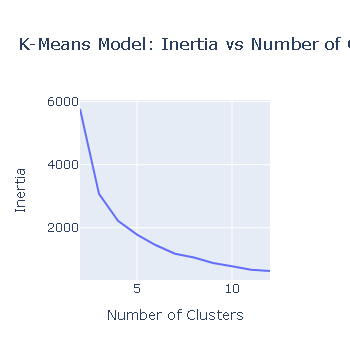

In [114]:
# Create line plot of `inertia_errors` vs `n_clusters`

fig = px.line(x=n_clusters,y=inertia_errors,title="K-Means Model: Inertia vs Number of Clusters")
fig.update_layout(xaxis_title="Number of Clusters",yaxis_title="Inertia")
fig.show()

And let's do the same thing with our Silhouette Scores.

#### Task 6.5.15

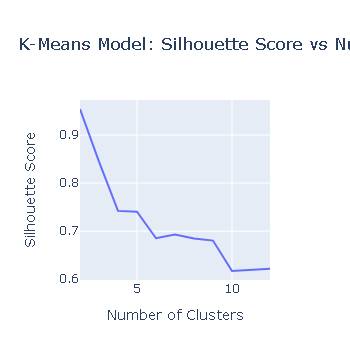

In [116]:
# Create a line plot of `silhouette_scores` vs `n_clusters`

fig = px.line(x=n_clusters,y=silhouette_scores,title="K-Means Model: Silhouette Score vs Number of Clusters")
fig.update_layout(xaxis_title="Number of Clusters",yaxis_title="Silhouette Score")
fig.show()

How many clusters should we use? When you've made a decision about that, it's time to build the final model.

#### Task 6.5.16

<div class="alert alert-info" role="alert">
    <b>Note:</b> For reproducibility, make sure you set the random state for your model to <code>42</code>. 
</div>

In [120]:
final_model = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=3,n_init=10,random_state=42)
)
final_model.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, n_init=10, random_state=42))])

# Communicate

Excellent! Let's share our work! 

#### Task 6.5.17

In [122]:
labels = final_model.named_steps["kmeans"].labels_
xgb = X.groupby(labels).mean()
xgb

,BUS,NHNFIN,NFIN,NETWORTH,ASSET
0,7.367185e+05,1.002199e+06,1.487967e+06,2.076003e+06,2.281249e+06
1,1.216152e+07,1.567619e+07,1.829123e+07,2.310024e+07,2.422602e+07
2,6.874479e+07,8.202115e+07,9.169652e+07,1.134843e+08,1.167529e+08


As usual, let's make a visualization with the DataFrame.

#### Task 6.5.18

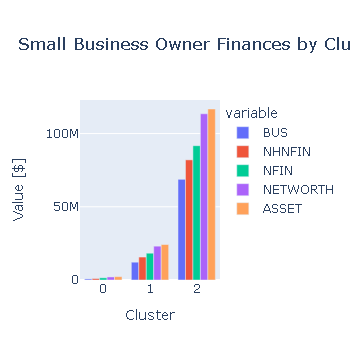

In [127]:
# Create side-by-side bar chart of `xgb`
fig=px.bar(
    xgb,barmode="group",title="Small Business Owner Finances by Cluster")

fig.update_layout(xaxis_title="Cluster",yaxis_title="Value [$]")
fig.show()

Remember what we did with higher-dimension data last time? Let's do the same thing here.

#### Task 6.5.19

In [131]:
# Instantiate transformer
pca = PCA(n_components=2,random_state=42)

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t,columns=["PC1","PC2"])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (4364, 2)


,PC1,PC2
0,-6.220648e+06,-503841.638835
1,-6.222523e+06,-503941.888901
2,-6.220648e+06,-503841.638839
3,-6.224927e+06,-504491.429465
4,-6.221994e+06,-503492.598399


Finally, let's make a visualization of our final DataFrame.<span style='color: transparent; font-size:1%'>WQU WorldQuant University Applied Data Science Lab QQQQ</span>

#### Task 6.5.20

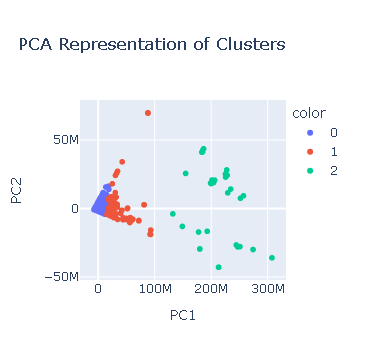

In [135]:
# Create scatter plot of `PC2` vs `PC1`
fig=px.scatter(X_pca,x="PC1",y="PC2",color=labels.astype(str),
                  title="PCA Representation of Clusters")
fig.update_layout(xaxis_title="PC1",yaxis_title="PC2")
fig.show()

---
Copyright 2023 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
